### Multi-Hop Retrieval for Deep Reasoning

Many complex user queries are not single questions at all, they are comparative, multi-step research tasks that require synthesizing information from multiple, disparate documents.

<p align="center">
  <img src="../../figures/multi_hop_retrieval.png" width="800">
</p>

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Parallel Multi-Hop Retrieval architecture is the solution. This pattern elevates the RAG system into a true research agent. The workflow mirrors how a human researcher would tackle a complex question:

1. Decompose: A high-level Meta-Agent first analyzes the complex user query and breaks it down into several simpler, independent sub-questions.
2. Scatter (Parallel Retrieval): Each sub-question is dispatched to its own dedicated Retrieval Agent. These agents run in parallel, each performing a standard RAG process to find the answer to its specific sub-question.
3. Gather & Synthesize: The Meta-Agent collects the answers to all the sub-questions and then performs a final reasoning step to synthesize them into a single, comprehensive answer to the original complex query.

We will build and compare a Simple RAG system with a Multi-Hop RAG system on a comparative question that is impossible to answer with a single retrieval. We will demonstrate that only the Multi-Hop system can successfully gather the necessary evidence to provide an accurate and insightful final answer.

### Creating the Knowledge Base

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document

kb_docs = [
    Document(page_content="The QLeap-V4 processor is designed for maximum performance in data centers. It consumes 1200W of power under full load and uses a specialized liquid cooling system to manage heat.", metadata={"product": "QLeap-V4"}),
    Document(page_content="Key features of the QLeap-V4 include 128 tensor cores and a 3nm process node, making it ideal for large-scale AI model training.", metadata={"product": "QLeap-V4"}),
    Document(page_content="The Eco-AI-M2 chip is designed for edge computing and mobile devices. Its primary feature is low power consumption, drawing only 15W under full load.", metadata={"product": "Eco-AI-M2"}),
    Document(page_content="Built on a 7nm process node, the Eco-AI-M2 has 8 specialized neural cores, making it perfect for real-time inference on devices like drones and smart cameras.", metadata={"product": "Eco-AI-M2"})
]

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(kb_docs, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

print(f"Knowledge Base created with {len(kb_docs)} documents.")

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_34450/3486095030.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Knowledge Base created with 4 documents.


### Structured Data Models

In [4]:
from pydantic import BaseModel, Field
from typing import List

class SubQuestions(BaseModel):
    """A list of independent sub-questions to be answered in parallel."""
    questions: List[str] = Field(description="A list of 2-3 simple, self-contained questions that, when answered together, will fully address the original complex query.")

### The Baseline - A Simple RAG System

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

generator_prompt_template = (
    "You are an expert AI hardware analyst. Answer the user's question with high accuracy, based *only* on the following context. "
    "Synthesize the information into a clear, comparative answer.\n\n"
    "Context:\n{context}\n\nQuestion: {question}"
)
generator_prompt = ChatPromptTemplate.from_template(generator_prompt_template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

simple_rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | generator_prompt
    | llm
| StrOutputParser()
)

### Building the Multi-Hop RAG Graph

In [15]:
from typing import TypedDict, List, Dict, Annotated
from langchain_core.documents import Document
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain_core.output_parsers import JsonOutputParser

class MultiHopRAGState(TypedDict):
    original_question: str
    sub_questions: List[str]
    # The dict will store the answer to each sub-question
    sub_question_answers: Annotated[Dict[str, str], lambda a, b: {**a, **b}]
    final_answer: str

# Node 1: Decomposer (The Meta-Agent)
decomposer_parser = JsonOutputParser(
    pydantic_object=SubQuestions
)
decomposer_prompt = ChatPromptTemplate.from_template(
    "You are a query decomposition expert. Your job is to break down a complex question into simple, independent sub-questions that can be answered by a retrieval system. "
    "Do not try to answer the questions yourself.\n\n{format_instructions}\n\n"
    "Question: {question}",
).partial(format_instructions=decomposer_parser.get_format_instructions())
decomposer_chain = decomposer_prompt | llm | decomposer_parser

def decomposer_node(state: MultiHopRAGState):
    print("--- [Meta-Agent] Decomposing complex question... ---")
    result = decomposer_chain.invoke({"question": state['original_question']})
    print(f"--- [Meta-Agent] Generated {len(result["questions"])} sub-questions. ---")
    return {"sub_questions": result["questions"]}

In [16]:
# Node 2: Parallel Retrieval Agents
# This is a self-contained RAG chain that answers a single, simple question.
sub_question_rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | generator_prompt
    | llm
    | StrOutputParser()
)

def retrieval_agent_node(state: MultiHopRAGState):
    """Runs a RAG process for each sub-question in parallel."""
    print(f"--- [Retrieval Agents] Answering {len(state['sub_questions'])} sub-questions in parallel... ---")
    
    answers = {}
    with ThreadPoolExecutor(max_workers=len(state['sub_questions'])) as executor:
        # Map each sub-question to the RAG chain
        future_to_question = {executor.submit(sub_question_rag_chain.invoke, q): q for q in state['sub_questions']}
        for future in as_completed(future_to_question):
            question = future_to_question[future]
            try:
                answer = future.result()
                answers[question] = answer
                print(f"  - Answer found for sub-question: '{question}'")
            except Exception as e:
                answers[question] = f"Error answering question: {e}"

    return {"sub_question_answers": answers}

In [17]:
# Node 3: Synthesizer (The Meta-Agent's final step)
synthesizer_prompt = ChatPromptTemplate.from_template(
    "You are a synthesis expert. Your job is to combine the answers to several sub-questions into a single, cohesive, and comprehensive answer to the user's original complex question.\n\n"
    "Original Question: {original_question}\n\n"
    "Sub-Question Answers:\n{sub_question_answers}"
)
synthesizer_chain = synthesizer_prompt | llm | StrOutputParser()

def synthesizer_node(state: MultiHopRAGState):
    print("--- [Meta-Agent] Synthesizing final answer... ---")
    
    sub_answers_str = "\n".join([f"- Q: {q}\n- A: {a}" for q, a in state['sub_question_answers'].items()])
    
    final_answer = synthesizer_chain.invoke({
        "original_question": state['original_question'],
        "sub_question_answers": sub_answers_str
    })
    return {"final_answer": final_answer}

In [18]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(MultiHopRAGState)

workflow.add_node("decompose", decomposer_node)
workflow.add_node("retrieve_in_parallel", retrieval_agent_node)
workflow.add_node("synthesize", synthesizer_node)

workflow.set_entry_point("decompose")
workflow.add_edge("decompose", "retrieve_in_parallel")
workflow.add_edge("retrieve_in_parallel", "synthesize")
workflow.add_edge("synthesize", END)

multi_hop_rag_app = workflow.compile()

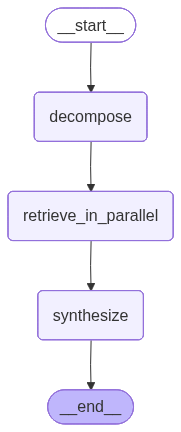

In [19]:
from IPython.display import Image
Image(multi_hop_rag_app.get_graph().draw_mermaid_png())

### Comparison

In [12]:
user_query = "Compare the QLeap-V4 and the Eco-AI-M2, focusing on their target use case and power consumption."

### Simple RAG System

In [13]:
print("="*60)
print("                  SIMPLE RAG SYSTEM OUTPUT")
print("="*60 + "\n")

# We intercept the retrieval step to inspect the documents
simple_retrieved_docs = retriever.invoke(user_query)

print("Retrieved Context:")
print(format_docs(simple_retrieved_docs) + "\n")

simple_answer = simple_rag_chain.invoke(user_query)
print("Final Answer:")
print(simple_answer)

                  SIMPLE RAG SYSTEM OUTPUT



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Retrieved Context:
The QLeap-V4 processor is designed for maximum performance in data centers. It consumes 1200W of power under full load and uses a specialized liquid cooling system to manage heat.

The Eco-AI-M2 chip is designed for edge computing and mobile devices. Its primary feature is low power consumption, drawing only 15W under full load.

Final Answer:
The QLeap-V4 and the Eco-AI-M2 are optimized for different use cases and exhibit significant differences in power consumption.

The QLeap-V4 is designed for data center environments, where high computational performance is critical. It consumes 1200W under full load, reflecting its capability to handle intensive workloads typical of large-scale data center operations. Its power demand is justified by its performance-oriented design and reliance on a specialized liquid cooling system to manage heat.

In contrast, the Eco-AI-M2 is tailored for edge computing and mobile devices, where energy efficiency and battery life are paramou

### Running the Multi-Hop RAG System

In [20]:
inputs = {"original_question": user_query}
multi_hop_result = None
for output in multi_hop_rag_app.stream(inputs, stream_mode="values"):
    multi_hop_result = output

print("="*60)
print("                 MULTI-HOP RAG SYSTEM OUTPUT")
print("="*60 + "\n")

print("--- Sub-Question Answers ---")
for i, (q, a) in enumerate(multi_hop_result['sub_question_answers'].items()):
    print(f"{i+1}. Q: {q}")
    print(f"   A: {a}")

print("\n--- Final Synthesized Answer ---")
print(multi_hop_result['final_answer'])

--- [Meta-Agent] Decomposing complex question... ---
--- [Meta-Agent] Generated 4 sub-questions. ---
--- [Retrieval Agents] Answering 4 sub-questions in parallel... ---
  - Answer found for sub-question: 'What is the power consumption of the QLeap-V4?'
  - Answer found for sub-question: 'What is the power consumption of the Eco-AI-M2?'
  - Answer found for sub-question: 'What is the target use case for the QLeap-V4?'
  - Answer found for sub-question: 'What is the target use case for the Eco-AI-M2?'
--- [Meta-Agent] Synthesizing final answer... ---
                 MULTI-HOP RAG SYSTEM OUTPUT

--- Sub-Question Answers ---
1. Q: What is the power consumption of the QLeap-V4?
   A: The power consumption of the QLeap-V4 is 1200W under full load.
2. Q: What is the power consumption of the Eco-AI-M2?
   A: The power consumption of the Eco-AI-M2 is 15W under full load.
3. Q: What is the target use case for the QLeap-V4?
   A: The target use case for the QLeap-V4 is large-scale AI model train